In [ ]:
import sys
sys.path.append('/Users/evatakou/noise_est')

import stim
from sims.surface_code_bare_ancilla.circuit_SC import *
from estimation_funcs_surface_code import *
from utilities.utils_for_decoding import decode_both_dems_same_data
from construct_dem import *
from utilities.general_utils import avg_vi


In [2]:
def get_DEM(distance,num_rounds,num_shots,p_depol_data,p_depol_anc,p_depol_after,depol_type_after_gates):

    L             = distance
    num_ancilla   = L*(L-1)
    Reset         = True

    circuit    = planar_surface_code_circuit_X_memory(distance,num_rounds,p_depol_data,p_depol_anc,Reset,p_depol_after,depol_type_after_gates)

    if p_depol_data==0 and p_depol_anc==0 and p_depol_after==0:
        my_DEM = stim.DetectorErrorModel()
        return my_DEM,circuit
    
    
    defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)
    vi_mean                        = avg_vi(defects_matrix)
    
    pij_time         = estimate_time_edge_probs(num_rounds,num_ancilla,defects_matrix,vi_mean)
    pij_bulk,pij_bd  = estimate_bulk_and_bd_edge_probs(num_rounds,num_ancilla,distance,defects_matrix,pij_time,vi_mean)
    
    my_DEM =surface_code_DEM(pij_bulk,pij_bd,pij_time,circuit.detector_error_model())

    return my_DEM,circuit





Running for L: 3
Running for L: 5


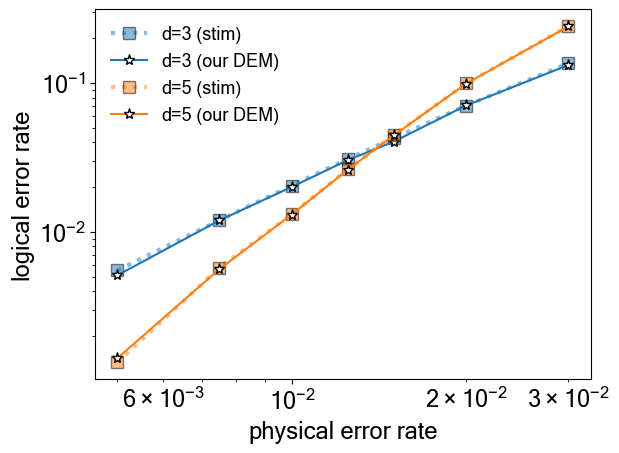

In [3]:
#W/ PARALLEL PROCESSING

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"

fig, ax = plt.subplots()

Ls            = [3,5] 
ps            = np.array([0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02, 0.03])
num_shots     = 200_000
num_shots_dec = 200_000
depol_type_after_gates = "DEPOLARIZE2"
colors    = ["tab:blue", 'tab:orange', "tab:green", "tab:purple", "tab:cyan", "tab:gray"]

def run_single_p(L, p):
    my_DEM, circuit                    = get_DEM(L, L, num_shots, p, p, p, depol_type_after_gates)
    num_errors_my_DEM, num_errors_stim = decode_both_dems_same_data(my_DEM, circuit, num_shots_dec)

    return num_errors_stim / num_shots, num_errors_my_DEM / num_shots

all_errors_STIM = []
all_errors_MDEM = []

for cnt, L in enumerate(Ls):
    print(f"Running for L: {L}")
    
    results = Parallel(n_jobs=-1)(
        delayed(run_single_p)(L, p) for p in ps
    )
    
    errors_per_p_stim, errors_per_p_my_DEM = zip(*results)
    
    all_errors_STIM.append(errors_per_p_stim)
    all_errors_MDEM.append(errors_per_p_my_DEM)

    plt.plot(ps, errors_per_p_stim, marker='s', linestyle=':', color=colors[cnt],
             linewidth=3, markeredgecolor='black', markersize=9, alpha=0.5)
    
    plt.plot(ps, errors_per_p_my_DEM, marker='*', color=colors[cnt],
             markersize=8, markeredgecolor='black', markerfacecolor='white')

plt.xscale('log')
plt.yscale('log')

plt.legend(['d=3 (stim)', 'd=3 (our DEM)',
            'd=5 (stim)', 'd=5 (our DEM)',
            'd=7 (stim)', 'd=7 (our DEM)',
            'd=9 (stim)', 'd=9 (our DEM)',
            'd=11 (stim)', 'd=11 (our DEM)',
            'd=13 (stim)', 'd=13 (our DEM)'],
           frameon=False, shadow=True, fontsize=13)

plt.xlabel('physical error rate')
plt.ylabel('logical error rate') 
plt.show()


#Uncomment to save the figure
# fig.savefig("threshold.pdf",bbox_inches='tight')

In [ ]:
#To save the data:

with open("stims_LE_threshold.txt", "w") as file:
    file.write(str(all_errors_STIM))
with open("all_errors_my_DEM.txt", "w") as file:
    file.write(str(all_errors_MDEM))    
with open("ps_threshold.txt", "w") as file:
    file.write(str(ps))   
with open("Ls_threshold.txt", "w") as file:
    file.write(str(Ls))   
    